## New Experimental Approach

#### generating trials  
-> each trial consists of multiple objects, and a final location for the pointing task
 - the trials are configured with the `config` variable
   - there OBJECT_PER_TRIAL objects per trial + another location for the pointing task
   - each trial is configured with;
     - the distance between the objects as determined with a range, specific to trial configuration.what kind of experimental controls?  
     - whether the trial includes crossing the boundary (same setting for all objects within)  
       - [] validate that there actually is at least one crossing, if crossing is allowed
     - border visibility for the trial, specified for the entire trial (not individual movements)
       - [] add this in
 - we do not keep any distances discrete
   - real world includes noise; for now we are assuming that these variables will be continuous. Therefore,
   - [] we will want to verify that our distances have consistent means and variances.
 - [] validate that the pointing ground-truth is above a threshold (> 0.5m)
 
    
#### object display
- participant moves from target to target, revealing the next one each time
 - the object is always visible. if it is on the other side & blocked by boundary, they will know because they won't be able to see it
- objects are the same geometrical shapes of different colors
  - make sure that the colors are color-friendly
      - [] pick a good color scheme
      - [] ask participants about color-blindness
  - vary shape and color from a random pool
    - this increases performance in recall, so that we can actually measure the distance bias
    - [] create a pool of different shapes and colors
    - [] pick randomly for each object
      - [] between participants, look into keeping the seed same
   
- [] investigate potential interference effect from proximity:
  - what's the average distance for the nth object?

#### pointing task / data collection / data analysis
- we want to control for the time and distance elapsed when moving, as well as the time taken for pointing
  - time taken pointing as a potential proxy for confidence?  
 
- we cue the participant for the object to recall
  - pointing task already has the participant inputting data by moving a pseudo-object
    - [] change this to the object that they actually saw 
  - we ask about the objects in a random permutation order
    - we can investigate recency & primacy already, permutation order could enhance or diminish those effects, look into it during analysis.
    
- [] make list of all variables we will be tracking during the analysis.

#### implementation
[ ] look into the unity implementation and think about how we can integrate these changes there
    [ ] if possible, start revamping the experiment to follow this approach with some dummy testing trials  

In [114]:
import random
import math
import matplotlib.pyplot as plt
import time
import numpy as np

In [241]:
OBJECT_PER_TRIAL = 5

WIDTH = 4
LENGTH = 6 # boundary is half-way within length

PLOT_INDIVIDUAL = True
PLOT_ALL = True

In [242]:
# define Point class that will provide some methods of convenience
class Point():
    def __init__(self, x = None, y = None):
        self.x = x
        self.y = y
        
    def __sub__(self, other):
        if not isinstance(other, Point):
            return NotImplementedError()
        else:
            return Point(self.x - other.x, self.y - other.y)
        
    def __add__(self, other):
        if not isinstance(other, Point):
            return NotImplementedError()
        else:
            return Point(self.x + other.x, self.y + other.y)
        
    def __repr__(self):
        return "P(" + str(round(self.x, 2)) + ", " + str(round(self.y, 2)) + ")"
        
    def dist(self, other):
        diff = self - other
        return diff.magnitude()
    
    def magnitude(self):
        return (self.x**2 + self.y**2) ** 0.5
    
    @staticmethod
    def random_circ(dist = 1):
        '''
        generates a random point with the given distance
        defaults to dist = 1 if no distance (on unit circle)
        '''
        theta = random.random() * 360
        x = math.cos(theta) * dist
        y = math.sin(theta) * dist
        
        return Point(x, y)

    @staticmethod
    def random_rect(w = WIDTH, l = LENGTH):
        x = random.random() * w
        y = random.random() * l
        
        return Point(x, y)
        

# test distance and __sub__ functionality (dist uses __sub__)
p1 = Point(0,0)
p2 = Point(3,4)
p1.dist(p2)

5.0

In [249]:
def generate_rand_movement(distance, start = None):
    
    if not start: # no start point given, generate within the rectangle
        start = Point.random_rect()
        
    end = start + Point.random_circ(distance)
    return (start, end)

def validate_movement(start, end, cross, hasBorder):
    buffer = 0.05
    x_lo = buffer * width
    x_hi = (1 - buffer) * width
    
    y_lo = buffer * length
    y_hi = (1 - buffer) * length
    
    border_lo = (length / 2) - length * buffer
    border_hi = (length / 2) + length * buffer
    
    mid_y = length / 2
    
    isOnSameSide = (start.y >= mid_y) == (end.y >= mid_y)
    
    crossIsCorrect = (isOnSameSide != cross)
    
    bufferFromBoundary = (x_lo < start.x < x_hi) and (x_lo < end.x < x_hi) and (y_lo < start.y < y_hi) and (y_lo < end.y < y_hi)
    bufferFromBorder = not hasBorder or not (border_lo < start.y < border_hi or border_lo < end.y < border_hi)
    
    # debug
    #print(start, end)
    #print(isOnSameSide, cross, crossIsCorrect, start.y >= mid_y, end.y >= mid_y)
    #print(crossIsCorrect , bufferFromBoundary , bufferFromBorder)
    
    return crossIsCorrect and bufferFromBoundary and bufferFromBorder

def generate_valid_movement(dist_min, dist_max, cross, hasBorder, start_from = None):
    tries = 0
    max_tries = 10000
    
    while tries < max_tries:
        distance = random.random() * (dist_max - dist_min) + dist_min
        start, end = generate_rand_movement(distance, start_from)
        tries += 1
        
        if validate_movement(start, end, cross, hasBorder):
            print(start, end, validate_movement(start, end, cross, hasBorder))
            return [start, end]
        
    print(distance, cross, " failed after ", tries , " tries")
    
def generate_valid_trial(dist_min, dist_max, crossBoundary, n = OBJECT_PER_TRIAL,):

    prev = None
    trial = []
    
    for obj in range(n-1 + 1): # we add another point at the end for the location from which they'll point to the objects
        # placeholder until we find what specific distance we would like to find
        random_border = random.random() > 0.5
        
        start, end = generate_valid_movement(dist_min, dist_max, crossBoundary, random_border, prev)
        if not prev:
            trial.append(start)
            
        trial.append(end)
        prev = end
    return trial

In [255]:
config = {
    "trials": [
        { # within boundary
            "distanceMin": 0.9,
            "distanceMax": 1.8,
            "crossBoundary": "False",
            "count": 2
        },
        { # across boundary
            "distanceMin": 1.5,
            "distanceMax": 4,
            "crossBoundary": "True",
            "count": 2
        }
    ]
}

trials = [] # a trial is a set of points, with the last one being where predictions are made from

for cfg_trial in config["trials"]:
    for cfg_trial_i in range(cfg_trial["count"]):
        trials.append(generate_valid_trial(cfg_trial["distanceMin"], cfg_trial["distanceMax"], cfg_trial["crossBoundary"] == "True"))
trials

P(3.61, 2.56) P(2.74, 1.65) True
P(2.74, 1.65) P(1.72, 1.48) True
P(1.72, 1.48) P(2.9, 0.48) True
P(2.9, 0.48) P(2.06, 0.98) True
P(2.06, 0.98) P(3.39, 1.5) True
P(1.68, 0.85) P(0.34, 0.83) True
P(0.34, 0.83) P(0.98, 2.05) True
P(0.98, 2.05) P(1.38, 0.37) True
P(1.38, 0.37) P(2.12, 1.61) True
P(2.12, 1.61) P(3.45, 1.78) True
P(3.61, 3.07) P(1.07, 1.24) True
P(1.07, 1.24) P(0.36, 4.72) True
P(0.36, 4.72) P(0.69, 2.49) True
P(0.69, 2.49) P(3.32, 3.35) True
P(3.32, 3.35) P(1.7, 1.8) True
P(0.58, 2.08) P(0.97, 3.77) True
P(0.97, 3.77) P(1.77, 1.21) True
P(1.77, 1.21) P(1.92, 3.66) True
P(1.92, 3.66) P(0.46, 1.08) True
P(0.46, 1.08) P(1.76, 3.11) True


[[P(3.61, 2.56),
  P(2.74, 1.65),
  P(1.72, 1.48),
  P(2.9, 0.48),
  P(2.06, 0.98),
  P(3.39, 1.5)],
 [P(1.68, 0.85),
  P(0.34, 0.83),
  P(0.98, 2.05),
  P(1.38, 0.37),
  P(2.12, 1.61),
  P(3.45, 1.78)],
 [P(3.61, 3.07),
  P(1.07, 1.24),
  P(0.36, 4.72),
  P(0.69, 2.49),
  P(3.32, 3.35),
  P(1.7, 1.8)],
 [P(0.58, 2.08),
  P(0.97, 3.77),
  P(1.77, 1.21),
  P(1.92, 3.66),
  P(0.46, 1.08),
  P(1.76, 3.11)]]

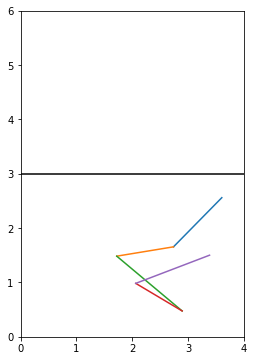

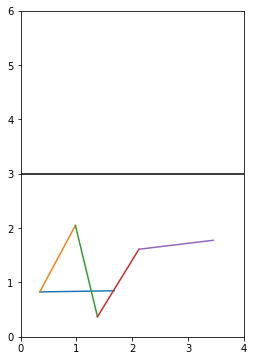

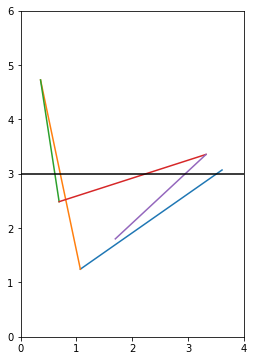

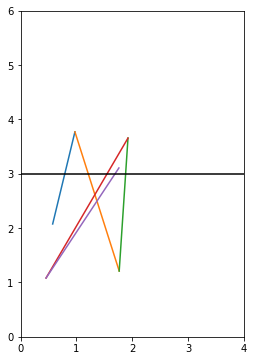

In [256]:
def plot_trial(trial):
    fig, ax = plt.subplots(figsize=(width, length))
    
    prev = trial[0]
    for curr in trial[1:]:
        plt.plot([prev.x,curr.x], [prev.y,curr.y])
        prev = curr

    # plot the border in any case
    plt.plot([0, width],[length/2, length/2], "k-")
    
    plt.xlim(0, width)
    plt.ylim(0, length)
    plt.show()
    
for trial in trials:
    plot_trial(trial)
          
#    
#if PLOT_ALL:
    # plot all together
    
   # fig, ax = plt.subplots(figsize=(width, length))
   # plt.xlim([0, width])
   # plt.ylim([0, length])
   # for trial in trials:
   #     x,y,v,w = tuple(trial[:4])
   #     ax.plot([x,v], [y,w])
   # plt.plot([0, width],[length/2, length/2], "--r")
   # plt.show()